# 3.2

# Data Loader

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import math
import pandas as pd

def load_data(batch_size=128):
    """Load CIFAR-100 dataset."""
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
        transforms.Resize(224),
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
        transforms.Resize(224),
    ])
    
    trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    
    testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    return trainloader, testloader

# Base Teacher Model - VGG16

In [3]:
class TeacherModel(nn.Module):
    def __init__(self):
        super().__init__()
        model = models.vgg16(pretrained=True)
        self.features = model.features
        self.pool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 100)
        )
        
        for param in model.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)  
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Basic Student Model - VGG11

In [5]:
from torchvision import models

class StudentModel(nn.Module):
    def __init__(self):
        super(StudentModel, self).__init__()
        model = models.vgg11(pretrained=True) 
        self.features = model.features
        model.classifier[-1] = nn.Linear(4096, 100)  
        self.classifier = model.classifier

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


# Fine Tuning Basic Teacher Model

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_teacher(model, trainloader, testloader, device, epochs=7):
    """Pretrain the teacher model on CIFAR-100."""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    best_acc = 0
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(trainloader, desc=f'Teacher Training Epoch {epoch + 1}/{epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100. * correct / total
        print(f'Teacher Training: Epoch {epoch + 1}, Loss: {epoch_loss:.3f}, Acc: {epoch_acc:.2f}%')
        
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        acc = 100. * correct / total
        print(f'Teacher Epoch {epoch + 1}: Validation Accuracy: {acc:.2f}%')
        
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), 'best_teacher.pth')
        
        scheduler.step()
    
    model.load_state_dict(torch.load('best_teacher.pth'))
    return model


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainloader, testloader = load_data()
teacher = TeacherModel().to(device)
teacher = train_teacher(teacher, trainloader, testloader, device)

# # Train with different KD methods
# train_student_with_logit_matching(student, teacher, trainloader, device)
# train_student_with_hints(student, teacher, trainloader, device)
# train_student_with_crd(student, teacher, trainloader, device)


100%|██████████| 169001437/169001437 [00:06<00:00, 27245895.15it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 208MB/s] 
Teacher Training Epoch 1/7: 100%|██████████| 391/391 [02:14<00:00,  2.90it/s]

Teacher Training: Epoch 1, Loss: 2.441, Acc: 37.02%


Teacher Epoch 1: Validation Accuracy: 57.74%


Teacher Training Epoch 2/7: 100%|██████████| 391/391 [02:13<00:00,  2.92it/s]

Teacher Training: Epoch 2, Loss: 1.551, Acc: 55.86%


Teacher Epoch 2: Validation Accuracy: 62.64%


Teacher Training Epoch 3/7: 100%|██████████| 391/391 [02:13<00:00,  2.93it/s]

Teacher Training: Epoch 3, Loss: 1.342, Acc: 61.25%


Teacher Epoch 3: Validation Accuracy: 64.97%


Teacher Training Epoch 4/7: 100%|██████████| 391/391 [02:13<00:00,  2.93it/s]

Teacher Training: Epoch 4, Loss: 1.200, Acc: 64.93%


Teacher Epoch 4: Validation Accuracy: 66.58%


Teacher Training Epoch 5/7: 100%|██████████| 391/391 [02:13<00:00,  2.92it/s]

Teacher Training: Epoch 5, Loss: 1.092, Acc: 67.81%


Teacher Epoch 5: Validation Accuracy: 67.79%


Teacher Training Epoch 6/7: 100%|██████████| 391/391 [02:13<00:00,  2.92it/s]

Teacher Training: Epoch 6, Loss: 1.000, Acc: 70.36%


Teacher Epoch 6: Validation Accuracy: 68.60%


Teacher Training Epoch 7/7: 100%|██████████| 391/391 [02:14<00:00,  2.92it/s]

Teacher Training: Epoch 7, Loss: 0.956, Acc: 71.72%


Teacher Epoch 7: Validation Accuracy: 69.04%


/tmp/ipykernel_30/1939661751.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_teacher.pth'))


In [6]:
import zipfile

zip_filename = 'best_teacher.zip'
model_filename = 'best_teacher.pth'
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    zipf.write(model_filename)

print(f'Zipped {model_filename} into {zip_filename}')


Zipped best_teacher.pth into best_teacher.zip


# Finetuning Basic Student Model

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd 

def train_model(model, trainloader, valloader, criterion, optimizer, epochs=5, save_path="student_model.pth"):
    model.train()
    
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(trainloader, desc=f'Epoch {epoch + 1}/{epochs}'):
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        epoch_train_loss = running_loss / len(trainloader)
        epoch_train_accuracy = 100 * correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)
        
        val_loss, val_correct, val_total = 0.0, 0, 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.cuda(), labels.cuda()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        epoch_val_loss = val_loss / len(valloader)
        epoch_val_accuracy = 100 * val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)
        
        print(f"Epoch {epoch + 1}/{epochs} | Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_accuracy:.2f}% | Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_accuracy:.2f}%")

    torch.save(model.state_dict(), save_path)
    print(f'Model saved as {save_path}')

    metrics_df = pd.DataFrame({
        'Epoch': range(1, epochs + 1),
        'Train Loss': train_losses,
        'Train Accuracy': train_accuracies,
        'Val Loss': val_losses,
        'Val Accuracy': val_accuracies
    })

    metrics_df.to_csv('basic_student_metrics.csv', index=False)
    print('Training metrics saved to basic_student_metrics.csv')

    return train_losses, train_accuracies, val_losses, val_accuracies


In [8]:

if __name__ == '__main__':
    trainloader, valloader = load_data()
    
    model = StudentModel().cuda()  
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    print("Fine-tuning for 2 epochs...")
    train_losses_2, train_accuracies_2, val_losses_2, val_accuracies_2 = train_model(
        model, trainloader, valloader, criterion, optimizer, epochs=2, save_path="trained_student_model_2_epochs.pth"
    )
    

    
# if __name__ == '__main__':
#     main()

Files already downloaded and verified
Files already downloaded and verified


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:02<00:00, 221MB/s]  


Fine-tuning for 2 epochs...


Epoch 1/2: 100%|██████████| 391/391 [03:24<00:00,  1.92it/s]


Epoch 1/2 | Train Loss: 2.0882 | Train Acc: 44.71% | Val Loss: 1.2398 | Val Acc: 63.44%


Epoch 2/2: 100%|██████████| 391/391 [03:23<00:00,  1.92it/s]


Epoch 2/2 | Train Loss: 1.0513 | Train Acc: 68.85% | Val Loss: 1.0141 | Val Acc: 70.24%
Model saved as trained_student_model_2_epochs.pth
Training metrics saved to basic_student_metrics.csv


In [12]:
 # Fine-tune the model for an additional 5 epochs
print("Fine-tuning for 5 additional epochs...")
train_losses_5, train_accuracies_5, val_losses_5, val_accuracies_5 = train_model(
    model, trainloader, valloader, criterion, optimizer, epochs=5, save_path="trained_student_model_5_epochs.pth"
)

Fine-tuning for 3 additional epochs...


Epoch 1/3: 100%|██████████| 391/391 [03:28<00:00,  1.87it/s]


Epoch 1/3 | Train Loss: 0.9863 | Train Acc: 70.68% | Val Loss: 1.0177 | Val Acc: 70.27%


Epoch 2/3: 100%|██████████| 391/391 [03:28<00:00,  1.87it/s]


Epoch 2/3 | Train Loss: 0.6447 | Train Acc: 80.21% | Val Loss: 0.9212 | Val Acc: 73.84%


Epoch 3/3: 100%|██████████| 391/391 [03:28<00:00,  1.87it/s]


Epoch 3/3 | Train Loss: 0.5073 | Train Acc: 84.29% | Val Loss: 0.9602 | Val Acc: 73.59%
Model saved as trained_student_model_5_epochs.pth
Training metrics saved to basic_student_metrics.csv


# Basic Logit Matching KD

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import pandas as pd

def train_with_logit_matching(student, teacher, train_loader, device, 
                            temperature=2.0, alpha=0.5, epochs=5, save_path='training_metrics.csv'):
    """
    Improved implementation of logit matching knowledge distillation.
    
    Args:
        student: Student model
        teacher: Teacher model
        train_loader: DataLoader for training data
        device: Device to run the models on
        temperature: Temperature for softening logits (default: 2.0)
        alpha: Weight for hard loss (default: 0.5)
        epochs: Number of training epochs (default: 5)
        save_path: Path to save the CSV file containing loss and accuracy
    """
    optimizer = optim.Adam(student.parameters(), lr=1e-4, weight_decay=5e-4)
    hard_criterion = nn.CrossEntropyLoss()
    soft_criterion = nn.KLDivLoss(reduction="batchmean")
    
    teacher.eval()  
    epoch_losses = []
    epoch_accuracies = []
    
    for epoch in range(epochs):
        student.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            with torch.no_grad():
                teacher_logits = teacher(inputs)
            
            student_logits = student(inputs)
            soft_teacher = F.softmax(teacher_logits / temperature, dim=1)
            log_soft_student = F.log_softmax(student_logits / temperature, dim=1)
            
            distillation_loss = soft_criterion(log_soft_student, soft_teacher) * (temperature ** 2)
            hard_loss = hard_criterion(student_logits, labels)
            loss = (1 - alpha) * distillation_loss + alpha * hard_loss
            
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            _, predicted = student_logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_acc)
        
        print(f'Epoch {epoch+1}: Loss = {epoch_loss:.3f}, Accuracy = {epoch_acc:.2f}%')
    
    metrics_df = pd.DataFrame({
        'Epoch': list(range(1, epochs+1)),
        'Loss': epoch_losses,
        'Accuracy': epoch_accuracies
    })
    
    metrics_df.to_csv(save_path, index=False)
    
    return student


In [10]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


teacher_model = TeacherModel().to(device)
teacher_model.load_state_dict(torch.load("/kaggle/input/lmteacher/pytorch/default/1/best_teacher.pth"))
teacher_model.eval()  

student_model = StudentModel().to(device)
student_model.load_state_dict(torch.load("trained_student_model_2_epochs.pth"))
student_model.eval()  

trained_student_model = train_with_logit_matching(
    student=student_model, 
    teacher=teacher_model, 
    train_loader=trainloader, 
    device=device, 
    epochs=5, 
    alpha=0.5, 
    temperature=2.0, 
    save_path="training_metrics.csv"  
)

torch.save(trained_student_model.state_dict(), "student_with_logit_matching.pth")



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 195MB/s] 
/tmp/ipykernel_30/3935964990.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for 

Epoch 1: Loss = 1.024, Accuracy = 71.93%
Epoch 2: Loss = 0.889, Accuracy = 74.58%
Epoch 3: Loss = 0.826, Accuracy = 76.62%
Epoch 4: Loss = 0.780, Accuracy = 78.18%
Epoch 5: Loss = 0.745, Accuracy = 79.54%


In [11]:
def evaluate_model(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    acc = 100. * correct / total
    print(f'Model Test Accuracy: {acc:.2f}%')
    return acc



# Contrastive Representation Distillation

# CRD Student & Teacher


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import pandas as pd

class TeacherModelCRD(nn.Module):
    def __init__(self):
        super().__init__()
        model = models.vgg16(pretrained=True)
        self.features = model.features
        self.avgpool = model.avgpool
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 100)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
    def get_features(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier[:-1](x) 
        return x

class StudentModelCRD(nn.Module):
    def __init__(self):
        super().__init__()
        
        vgg11 = models.vgg11(pretrained=True)
        self.features = vgg11.features 
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 1024),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 100) 
        )
        
        self.projection = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(True)
        )
        
        self.apply(self._init_weights)  
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        x = self.features(x)
        x = nn.AdaptiveAvgPool2d((7, 7))(x) 
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
    def get_features(self, x):
        x = self.features(x)
        x = nn.AdaptiveAvgPool2d((7, 7))(x)
        x = torch.flatten(x, 1)
        x = self.classifier[:-1](x)  
        x = self.projection(x)  
        return x

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from tqdm import tqdm

def train_model(model, trainloader, testloader, device, epochs=1, lr=1e-4, model_name='model'):
    """Generic training loop for both teacher and student models with progress tracking."""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = MultiStepLR(optimizer, milestones=[60, 120, 160], gamma=0.2)
    
    best_acc = 0
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        with tqdm(total=len(trainloader), desc=f"Epoch {epoch + 1}/{epochs}", unit="batch") as pbar:
            for i, (inputs, labels) in enumerate(trainloader):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                pbar.update(1)
                pbar.set_postfix(loss=loss.item(), accuracy=100. * correct / total)

        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100. * correct / total
        print(f'Training: Epoch {epoch + 1}, Loss: {epoch_loss:.3f}, Acc: {epoch_acc:.2f}%')
        
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        acc = 100. * correct / total
        print(f'Epoch {epoch + 1}: Validation Accuracy: {acc:.2f}%')
        
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), f'{model_name}_best_model.pth')
        
        scheduler.step() 
    
    model.load_state_dict(torch.load(f'{model_name}_best_model.pth'))
    return model


**Finetune teacher**

In [4]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 128
trainloader, testloader = load_data(batch_size)

teacher_model = TeacherModelCRD().to(device)
teacher_model = train_model(teacher_model, trainloader, testloader, device, epochs=7, lr=1e-4, model_name='teachercrd')


100%|██████████| 169001437/169001437 [00:06<00:00, 24910360.99it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 202MB/s] 
Epoch 1/7: 100%|██████████| 391/391 [06:20<00:00,  1.03batch/s, accuracy=43.3, loss=1.28]

Training: Epoch 1, Loss: 2.168, Acc: 43.26%


Epoch 1: Validation Accuracy: 65.54%


Epoch 2/7: 100%|██████████| 391/391 [06:19<00:00,  1.03batch/s, accuracy=64.2, loss=0.915]

Training: Epoch 2, Loss: 1.252, Acc: 64.24%


Epoch 2: Validation Accuracy: 68.53%


Epoch 3/7: 100%|██████████| 391/391 [06:19<00:00,  1.03batch/s, accuracy=70.9, loss=1.02] 

Training: Epoch 3, Loss: 0.998, Acc: 70.89%


Epoch 3: Validation Accuracy: 71.74%


Epoch 4/7: 100%|██████████| 391/391 [06:19<00:00,  1.03batch/s, accuracy=75.6, loss=0.655]

Training: Epoch 4, Loss: 0.827, Acc: 75.58%


Epoch 4: Validation Accuracy: 73.58%


Epoch 5/7: 100%|██████████| 391/391 [06:19<00:00,  1.03batch/s, accuracy=78.7, loss=0.645]

Training: Epoch 5, Loss: 0.709, Acc: 78.66%


Epoch 5: Validation Accuracy: 73.95%


Epoch 6/7: 100%|██████████| 391/391 [06:18<00:00,  1.03batch/s, accuracy=81.6, loss=0.75] 

Training: Epoch 6, Loss: 0.606, Acc: 81.60%


Epoch 6: Validation Accuracy: 75.35%


Epoch 7/7: 100%|██████████| 391/391 [06:19<00:00,  1.03batch/s, accuracy=83.9, loss=0.54] 

Training: Epoch 7, Loss: 0.524, Acc: 83.91%


Epoch 7: Validation Accuracy: 75.48%


/tmp/ipykernel_30/417066355.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{model_name}_best_model.pth'))


**Finetune Student**

In [5]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 128
trainloader, testloader = load_data(batch_size)

student_model = StudentModelCRD().to(device)
student_model = train_model(student_model, trainloader, testloader, device, epochs=2, lr=1e-4, model_name='studentcrd')


Files already downloaded and verified
Files already downloaded and verified


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:02<00:00, 209MB/s]  
Epoch 1/2: 100%|██████████| 391/391 [03:14<00:00,  2.01batch/s, accuracy=23.6, loss=1.97]

Training: Epoch 1, Loss: 3.096, Acc: 23.57%


Epoch 1: Validation Accuracy: 52.36%


Epoch 2/2: 100%|██████████| 391/391 [03:15<00:00,  2.00batch/s, accuracy=47, loss=1.97]  

Training: Epoch 2, Loss: 1.897, Acc: 46.95%


Epoch 2: Validation Accuracy: 60.41%


/tmp/ipykernel_30/417066355.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{model_name}_best_model.pth'))


# CRD LOSS

In [4]:

class DistillKL(nn.Module):
    def __init__(self, T):
        super(DistillKL, self).__init__()
        self.T = T

    def forward(self, y_s, y_t):
        p_s = nn.functional.log_softmax(y_s/self.T, dim=1)
        p_t = nn.functional.softmax(y_t/self.T, dim=1)
        loss = nn.KLDivLoss(reduction='batchmean')(p_s, p_t) * (self.T**2)
        return loss

class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, student_features, teacher_features):
        student_features = nn.functional.normalize(student_features, dim=1)
        teacher_features = nn.functional.normalize(teacher_features, dim=1)

        similarity = torch.matmul(student_features, teacher_features.T) / self.temperature
        labels = torch.arange(similarity.size(0), device=similarity.device)
        loss = nn.CrossEntropyLoss()(similarity, labels)
        
        return loss



# Train CRD Student & Teacher

In [9]:
import pandas as pd  

from tqdm import tqdm  

def train_epoch(teacher_model, student_model, trainloader, device, optimizer, kl_criterion, contrastive_criterion):
    student_model.train()
    teacher_model.eval()
    
    total_loss = 0
    total_samples = 0
    kl_losses = []
    contr_losses = []
    cls_losses = []

    progress_bar = tqdm(trainloader, desc="Training", unit="batch")

    for batch_idx, (inputs, targets) in enumerate(progress_bar):
        inputs, targets = inputs.to(device), targets.to(device)
        batch_size = inputs.size(0)
        
        optimizer.zero_grad()
        
        with torch.no_grad():
            teacher_outputs = teacher_model(inputs)
            teacher_features = teacher_model.get_features(inputs)
        
        student_outputs = student_model(inputs)
        student_features = student_model.get_features(inputs)
        
        kl_loss = kl_criterion(student_outputs, teacher_outputs)
        contr_loss = contrastive_criterion(student_features, teacher_features)
        cls_loss = nn.CrossEntropyLoss()(student_outputs, targets)
        
        loss = 0.5 * kl_loss + 0.1 * contr_loss + 0.4 * cls_loss
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * batch_size
        total_samples += batch_size
        
        kl_losses.append(kl_loss.item())
        contr_losses.append(contr_loss.item())
        cls_losses.append(cls_loss.item())

        progress_bar.set_postfix({
            'Loss': loss.item(),
            'KL Loss': kl_loss.item(),
            'Contr Loss': contr_loss.item(),
            'Cls Loss': cls_loss.item()
        })

    avg_loss = total_loss / total_samples
    return avg_loss, kl_losses, contr_losses, cls_losses


def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    accuracy = 100. * correct / total
    return accuracy

def train_and_save_metrics(teacher_model, student_model, trainloader, eval_loader, device, optimizer, kl_criterion, contrastive_criterion, epochs=5):
    all_kl_losses = []
    all_contr_losses = []
    all_cls_losses = []
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        avg_loss, kl_losses, contr_losses, cls_losses = train_epoch(
            teacher_model, student_model, trainloader, device, optimizer, kl_criterion, contrastive_criterion
        )
        
        all_kl_losses.extend(kl_losses)
        all_contr_losses.extend(contr_losses)
        all_cls_losses.extend(cls_losses)

        eval_accuracy = evaluate(student_model, eval_loader, device)
        print(f'Evaluation Accuracy: {eval_accuracy:.2f}%')

    metrics_df = pd.DataFrame({
        'KL Loss': all_kl_losses,
        'Contrastive Loss': all_contr_losses,
        'Classification Loss': all_cls_losses
    })

    metrics_df.to_csv('crd_metrics.csv', index=False)
    print('Training metrics saved to crd_metrics.csv')


In [10]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

batch_size = 128
num_epochs = 5
learning_rate = 1e-4
temperature = 4.0

trainloader, testloader = load_data(batch_size)

teacher_model = TeacherModelCRD().to(device)
teacher_model.load_state_dict(torch.load('/kaggle/input/crdteacher/pytorch/default/1/teachercrd_best_model.pth'))
teacher_model.eval()  


student_model_crd = StudentModelCRD().to(device)
try:
    student_model_crd.load_state_dict(torch.load('/kaggle/input/crdstudent/pytorch/default/1/studentcrd_best_model.pth'))
except FileNotFoundError:
    print("No pre-trained student model found, starting from scratch.")

optimizer_crd = optim.Adam(student_model_crd.parameters(), lr=learning_rate)
kl_criterion = DistillKL(temperature) 
contrastive_criterion = ContrastiveLoss()  

print("\nStarting training with Contrastive Representation Distillation...")
train_and_save_metrics(
    teacher_model, student_model_crd, trainloader, testloader, 
    device, optimizer_crd, kl_criterion, contrastive_criterion, 
    epochs=num_epochs
)

torch.save(student_model_crd.state_dict(), 'CRDfinal_student_model.pth')


Using device: cuda
Files already downloaded and verified
Files already downloaded and verified


/tmp/ipykernel_30/3269298347.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_model.load_state_dict(torch.load('/kaggle/input/crdteacher/pytorch/default/1/teache


Starting training with Contrastive Representation Distillation...
Epoch 1/5


Training: 100%|██████████| 391/391 [10:47<00:00,  1.66s/batch, Loss=3, KL Loss=4.68, Contr Loss=1.02, Cls Loss=1.4]    


Evaluation Accuracy: 64.16%
Epoch 2/5


Training: 100%|██████████| 391/391 [10:47<00:00,  1.66s/batch, Loss=3.03, KL Loss=4.71, Contr Loss=0.779, Cls Loss=1.49] 


Evaluation Accuracy: 67.21%
Epoch 3/5


Training: 100%|██████████| 391/391 [10:47<00:00,  1.66s/batch, Loss=2.08, KL Loss=3.02, Contr Loss=0.667, Cls Loss=1.27] 


Evaluation Accuracy: 68.43%
Epoch 4/5


Training: 100%|██████████| 391/391 [10:47<00:00,  1.66s/batch, Loss=2.55, KL Loss=3.68, Contr Loss=0.667, Cls Loss=1.62] 


Evaluation Accuracy: 69.55%
Epoch 5/5


Training: 100%|██████████| 391/391 [10:47<00:00,  1.66s/batch, Loss=2.14, KL Loss=3.25, Contr Loss=0.673, Cls Loss=1.12] 


Evaluation Accuracy: 70.19%
Training metrics saved to crd_metrics.csv


# Hint-Based Distillation

# Updated Student & Teacher models with Hint layers


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader

class HintTeacherModel(nn.Module):
    def __init__(self):
        super().__init__()
        model = models.vgg16(pretrained=True)
        self.features = model.features
        self.classifier = nn.Sequential(
            nn.Linear(25088, 4096), 
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 100)
        )
        
        for param in model.parameters():
            param.requires_grad = False
        
    def forward(self, x):
        features = self.features(x)
        hint_features = features 
        x = torch.flatten(features, 1)
        logits = self.classifier(x)
        
        return logits, hint_features


class HintStudentModel(nn.Module):
    def __init__(self):
        super().__init__()
        model = models.vgg11(pretrained=True)
        self.features = model.features
        
        dummy_input = torch.randn(1, 3, 224, 224)  
        dummy_output = self.features(dummy_input)
        flattened_size = dummy_output.view(dummy_output.size(0), -1).size(1) 
        self.regressor = nn.Conv2d(512, 512, kernel_size=1)

        self.classifier = nn.Sequential(
            nn.Linear(flattened_size, 2048),  
            nn.BatchNorm1d(2048),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.Linear(1024, 100)
        )
        
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)
            
    def forward(self, x):
        features = self.features(x)
        hint_features = self.regressor(features) 
        x = torch.flatten(features, 1)
        logits = self.classifier(x)
        
        return logits, hint_features


# Training student & teacher

In [3]:
def train_model(model, train_loader, val_loader, device, epochs=5, model_type='teacher'):
    """Train the model (teacher or student) with specified hyperparameters."""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4) 
    
    best_acc = 0.0
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs, _ = model(inputs) 
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_acc = 100. * correct / total
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs, _ = model(inputs) 
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_acc = 100. * correct / total
        print(f'Epoch {epoch + 1}: Train Loss = {running_loss / len(train_loader):.4f}, '
              f'Train Acc = {train_acc:.2f}%, Val Acc = {val_acc:.2f}%')
        
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f'best_{model_type}_hint.pth')
    
    model.load_state_dict(torch.load(f'best_{model_type}_hint.pth'))
    return model

**Finetuning teacher and student**

In [19]:

train_loader, val_loader = load_data(128)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
teacher_model = HintTeacherModel().to(device)
train_model(teacher_model, train_loader, val_loader, device, epochs=7, model_type='teacher')


Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train Loss = 2.4476, Train Acc = 37.16%, Val Acc = 57.69%
Epoch 2: Train Loss = 1.5551, Train Acc = 55.61%, Val Acc = 62.72%
Epoch 3: Train Loss = 1.3483, Train Acc = 60.79%, Val Acc = 65.71%
Epoch 4: Train Loss = 1.2241, Train Acc = 64.23%, Val Acc = 67.27%
Epoch 5: Train Loss = 1.1343, Train Acc = 66.71%, Val Acc = 67.79%
Epoch 6: Train Loss = 1.0503, Train Acc = 68.71%, Val Acc = 67.48%
Epoch 7: Train Loss = 0.9869, Train Acc = 70.60%, Val Acc = 68.83%


/tmp/ipykernel_30/713316720.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_{model_type}_hint.pth'))


HintTeacherModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loader, val_loader = load_data(128)
student_model = HintStudentModel().to(device)
train_model(student_model, train_loader, val_loader, device, epochs=2, model_type='student')

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train Loss = 3.8314, Train Acc = 12.69%, Val Acc = 21.26%
Epoch 2: Train Loss = 3.1699, Train Acc = 23.48%, Val Acc = 30.34%


/tmp/ipykernel_30/713316720.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_{model_type}_hint.pth'))


HintStudentModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_

In [4]:
import pandas as pd 
from tqdm import tqdm 

def train_hint_distillation(teacher, student, train_loader, val_loader, epochs, device, 
                           hint_weight=0.25, ce_weight=0.75):
    """Train the student model using hint-based distillation"""
    teacher.eval()
    student.train()
    
    criterion = nn.CrossEntropyLoss()
    hint_criterion = nn.MSELoss()
    optimizer = optim.SGD(student.parameters(),
                         lr=0.01,
                         momentum=0.9,
                         weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    best_acc = 0.0
    
    all_train_losses = []
    all_val_losses = []
    all_train_accuracies = []
    all_val_accuracies = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader, desc=f'Training Epoch {epoch + 1}/{epochs}', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            
            with torch.no_grad():
                _, teacher_hints = teacher(inputs)
            
            optimizer.zero_grad()
            student_logits, student_hints = student(inputs)
            
            ce_loss = criterion(student_logits, labels)
            hint_loss = hint_criterion(student_hints, teacher_hints)
            total_loss = ce_weight * ce_loss + hint_weight * hint_loss
            
            total_loss.backward()
            optimizer.step()
            
            running_loss += total_loss.item()
            _, predicted = student_logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
        train_acc = 100. * correct / total
        
        all_train_losses.append(running_loss / len(train_loader))
        all_train_accuracies.append(train_acc)
        
        student.eval()
        correct = 0
        total = 0
        val_loss = 0.0
        
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f'Validation Epoch {epoch + 1}/{epochs}', leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs, _ = student(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                val_loss += criterion(outputs, labels).item()
        
        student.train()
        val_acc = 100. * correct / total
        
        all_val_losses.append(val_loss / len(val_loader))
        all_val_accuracies.append(val_acc)
        
        print(f'Epoch {epoch + 1}: Loss = {running_loss / len(train_loader):.4f}, '
              f'Train Acc = {train_acc:.2f}%, Val Acc = {val_acc:.2f}%')
        
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(student.state_dict(), 'best_student_hint_distillation.pth')
            
        scheduler.step()
        
    metrics_df = pd.DataFrame({
        'Epoch': range(1, epochs + 1),
        'Train Loss': all_train_losses,
        'Train Accuracy': all_train_accuracies,
        'Val Loss': all_val_losses,
        'Val Accuracy': all_val_accuracies
    })


    metrics_df.to_csv('hint_metrics.csv', index=False)
    print('Training metrics saved to hint_metrics.csv')


In [10]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainloader, testloader = load_data(128)

teacher = HintTeacherModel().to(device)
student = HintStudentModel().to(device)

teacher.load_state_dict(torch.load('/kaggle/input/hintteacher/pytorch/default/1/best_teacher_hint.pth'))
print("Loaded teacher model.")

student.load_state_dict(torch.load('/kaggle/input/hintstudent/pytorch/default/1/best_student_hint.pth'))
print("Loaded student model.")

print("Training student with hint-based distillation...")
train_hint_distillation(
    teacher=teacher,
    student=student,
    train_loader=trainloader,
    val_loader=testloader,
    epochs=5,
    device=device,
    hint_weight=0.25,
    ce_weight=0.75
)

torch.save(student.state_dict(), 'best_student_hint_distillation.pth')
print("Finished training and saved the student model.")

def evaluate_model(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _ = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100. * correct / total

teacher_acc = evaluate_model(teacher, testloader, device)
student_acc = evaluate_model(student, testloader, device)

print(f"\nFinal Results:")
print(f"Teacher Accuracy: {teacher_acc:.2f}%")
print(f"Student Accuracy: {student_acc:.2f}%")


Files already downloaded and verified
Files already downloaded and verified


/tmp/ipykernel_30/2015401095.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load('/kaggle/input/hintteacher/pytorch/default/1/best_teache

Loaded teacher model.


/tmp/ipykernel_30/2015401095.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student.load_state_dict(torch.load('/kaggle/input/hintstudent/pytorch/default/1/best_studen

Loaded student model.
Training student with hint-based distillation...


Epoch 1: Loss = 2.1697, Train Acc = 29.25%, Val Acc = 30.41%


Epoch 2: Loss = 1.9207, Train Acc = 35.75%, Val Acc = 38.79%


Epoch 3: Loss = 1.7229, Train Acc = 41.46%, Val Acc = 44.88%


Epoch 4: Loss = 1.5703, Train Acc = 46.02%, Val Acc = 49.95%


Epoch 5: Loss = 1.4560, Train Acc = 49.68%, Val Acc = 52.79%
Training metrics saved to hint_metrics.csv
Finished training and saved the student model.

Final Results:
Teacher Accuracy: 68.83%
Student Accuracy: 52.79%


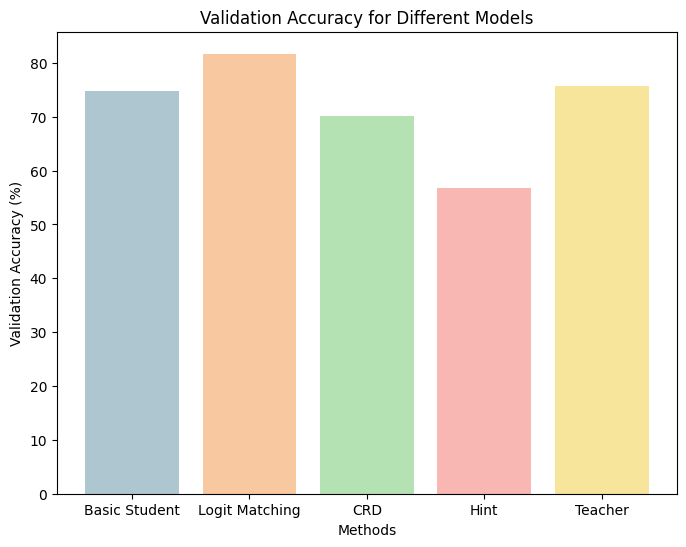

In [1]:
import matplotlib.pyplot as plt

# Data
methods = ['Basic Student', 'Logit Matching', 'CRD', 'Hint', 'Teacher']
accuracies = [74.70, 81.69, 70.19, 56.79, 75.72]

plt.figure(figsize=(8, 6))
plt.bar(methods, accuracies, color=['#aec6cf', '#f8c8a0', '#b5e2b3', '#f8b7b3', '#f7e59b'])

plt.xlabel('Methods')
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracy for Different Models')

plt.show()
